#  Import the Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#  Data Pre-Processing 

In [2]:
df_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
df_test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
print(df_test)
df_train.head()
df_test.head()

            ID  shop_id  item_id
0            0        5     5037
1            1        5     5320
2            2        5     5233
3            3        5     5232
4            4        5     5268
...        ...      ...      ...
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969

[214200 rows x 3 columns]


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [3]:
df_train.drop(['date_block_num','item_price'], axis=1, inplace=True)
df_train.info()
print(df_train['shop_id'])
df_train['date'] = pd.to_datetime(df_train['date'], dayfirst=True)
df_train['date'] = df_train['date'].apply(lambda x: x.strftime('%Y-%m'))
df_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   shop_id       int64  
 2   item_id       int64  
 3   item_cnt_day  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 89.6+ MB
0          59
1          25
2          25
3          25
4          25
           ..
2935844    25
2935845    25
2935846    25
2935847    25
2935848    25
Name: shop_id, Length: 2935849, dtype: int64


,date,shop_id,item_id,item_cnt_day
0,2013-01,59,22154,1.0
1,2013-01,25,2552,1.0
2,2013-01,25,2552,-1.0
3,2013-01,25,2554,1.0
4,2013-01,25,2555,1.0


In [4]:
X = df_train.groupby(['date','shop_id','item_id']).sum()
X = X.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
X.reset_index(inplace=True)
X.head()

date,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_t = pd.merge(df_test, X, on=['shop_id','item_id'], how='left')
X_t.drop(['ID'], axis=1, inplace=True)
u = X_t.select_dtypes(exclude=['datetime'])
X_t[u.columns] = u.fillna(0)
X_t.head()

,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
Y = X['2015-10'].values
X_T = X.drop(['2015-10'], axis = 1)
X_t = X_t.drop(['2015-10'], axis = 1)
print(X_T.shape, Y.shape)
print(X_t.shape)

(424124, 35) (424124,)
(214200, 35)


#  Correlation Analysis

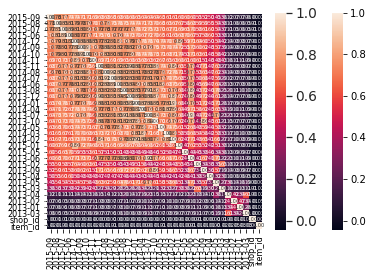

In [7]:
corrmat = X_t.corr()
sns.heatmap(corrmat,square= True)
k = 35
cols = corrmat.nlargest(k, '2015-09')['2015-09'].index
cm = np.corrcoef(X_t[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 5},yticklabels=cols.values, xticklabels=cols.values)
plt.tick_params(labelsize=8)
plt.show()

#  Modeling for Prediction

In [8]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [9]:
x_train, x_val, y_train, y_val = train_test_split(X_T, Y, test_size=0.2, random_state=3)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(339299, 35) (339299,)
(84825, 35) (84825,)


In [10]:
RF_reg = RandomForestRegressor(n_estimators = 100)
RF_reg.fit(x_train, y_train)

RandomForestRegressor()

In [11]:
val_pred = RF_reg.predict(x_val)
train_pred = RF_reg.predict(x_train)
print(val_pred)
print(train_pred)
print_evaluate(y_val, val_pred)
print_evaluate(y_train, train_pred)

[0.   0.   0.   ... 0.16 0.   0.  ]
[0.   0.1  0.   ... 0.58 0.03 0.  ]
MAE: 0.1626284703801945
MSE: 1.4881873952254643
RMSE: 1.2199128637839116
R2 Square 0.5945097793292966
__________________________________
MAE: 0.0647606683190932
MSE: 2.0516822622524673
RMSE: 1.4323694573162566
R2 Square 0.8928456400516975
__________________________________


In [12]:
test_pred = RF_reg.predict(X_t)
print('prediction for test data:',test_pred)
print(test_pred.shape)

prediction for test data: [0.07 0.75 0.87 ... 0.01 0.99 0.1 ]
(214200,)


[[     0      5   5037]
 [     1      5   5320]
 [     2      5   5233]
 ...
 [214197     45  15757]
 [214198     45  19648]
 [214199     45    969]]
[0.07 0.75 0.87 ... 0.01 0.99 0.1 ]


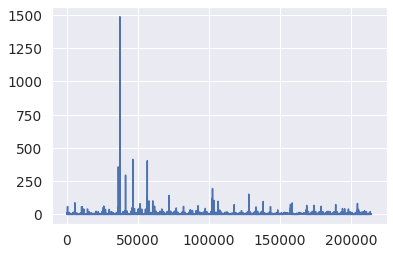

In [13]:
x = np.array(df_test)
print(x)
print(test_pred)
plt.plot(x[:,0:1],test_pred)
plt.show()

#  Submission

In [14]:
submission = pd.DataFrame({
    'ID':df_test['ID'],
    'item_cnt_month':test_pred
})
submission.to_csv('submission.csv', index=False)
print(submission)
submission.head()

            ID  item_cnt_month
0            0            0.07
1            1            0.75
2            2            0.87
3            3            0.16
4            4            0.76
...        ...             ...
214195  214195            0.65
214196  214196            1.03
214197  214197            0.01
214198  214198            0.99
214199  214199            0.10

[214200 rows x 2 columns]


,ID,item_cnt_month
0,0,0.07
1,1,0.75
2,2,0.87
3,3,0.16
4,4,0.76
